## CMSC 35300 Final Project: Models
Shweta Kamath <br>
Nivedita Vatsa <br>
Carolyn Vilter

#### Setup

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [150]:
# Import data
df = pd.read_csv("data/all_data.csv")

In [151]:
# Separate out Xs
X = df.loc[:, ~df.columns.isin(["child_id", "mother_id", "treat_alike_scale", "treat_alike_binary"])]
X = X.to_numpy()

# Separate out two prospective ys
y_scale = df.loc[:, df.columns == "treat_alike_scale"]
y_scale = y_scale.to_numpy()

y_binary = df.loc[:, df.columns == "treat_alike_binary"]
y_binary = y_binary.to_numpy()

### Least Squares
Predict repeatedly using cross validation; plot test error.

In [147]:
# Number of random trials
N = 100
# Store error values
errs = np.zeros(N)
# Number of observations/samples
n = X.shape[0]
# Chosen number of sets to divide dataset into
n_sets = 10
# Final index of the training set (9 of 10 subsets)
t_index = n//n_sets*(n_sets-1)

for i in range(N):
    # (re)assign training and hold-out indices
    r = np.random.permutation(n)
    it = r[:t_index]
    ih = r[t_index:]

    # Training data
    Xt = X[it, :]
    # Find w-hat using using training y_scale
    yt = y_scale[it]
    wt = np.linalg.inv(Xt.T@Xt)@Xt.T@yt

    # Apply w-hat to holdout data
    Xh = X[ih, :]
    yh = y_scale[ih]
    yhat = Xh@wt

    # Assign y-hat results to closest label: 1, 2, 3, or 4
    for idx, pred in enumerate(yhat):
        dists = []
        for label in range(1, 5):
            dists.append(abs(pred - label))
        match = dists.index(min(dists))
        yhat[idx] = match + 1

    errs[i] = np.mean(yhat != yh)

LinAlgError: Singular matrix

In [ ]:
np.unique(yhat)

array([2., 3., 4.])

Average error rate over all iterations: 0.6531721470019343


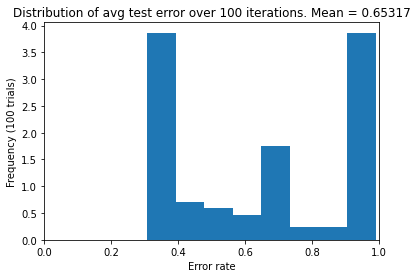

In [ ]:
avg_error = np.mean(errs)
print("Average error rate over all iterations:", avg_error)

# Plot histogram of error rates
plt.hist(errs, density=True, bins=8)
plt.xlim(0, 1)
plt.xlabel('Error rate')
plt.ylabel('Frequency (100 trials)')
plt.title('Distribution of avg test error over {:.0f} iterations. Mean = {:.5f}'.format(N, avg_error))
plt.show()